# Atelier 1 : Apprentissage supervisé avec Python

<hr>

In [7]:
from utils import *

<hr>

# I. Apprentissage supervisé : Feature engineering et Classification 

### Chargement des données et préparation

In [2]:
df = pd.read_csv("credit_scoring.csv",delimiter=";")
df.head(5)

,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price,Status
0,9.0,1.0,60.0,30.0,0.0,1.0,1.0,73.0,129.0,0.0,0.0,800.0,846.0,1
1,17.0,1.0,60.0,58.0,1.0,1.0,0.0,48.0,131.0,0.0,0.0,1000.0,1658.0,1
2,10.0,0.0,36.0,46.0,0.0,2.0,1.0,90.0,200.0,3000.0,0.0,2000.0,2985.0,0
3,0.0,1.0,60.0,24.0,1.0,1.0,0.0,63.0,182.0,2500.0,0.0,900.0,1325.0,1
4,0.0,1.0,36.0,26.0,1.0,1.0,0.0,46.0,107.0,0.0,0.0,310.0,910.0,1


In [3]:
df_np = df.to_numpy()

In [4]:
X = df_np[:, :-1]
target = df_np[:,-1]

In [5]:
print(target)
print(X)

[1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.

### Comparaison de plusieurs algorithmes d’apprentissage par validation croisée 

In [6]:
from utils import *
from sklearn.neural_network import MLPClassifier

In [7]:
clfs={
    'CART' : DecisionTreeClassifier(criterion='gini',random_state=1),
    'ID3' : DecisionTreeClassifier(criterion='entropy',random_state=1),
    'Stump' : DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5,n_jobs=-1),
    'Bag': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1),
                             n_estimators=200,random_state=1,n_jobs=-1),
    'Ad': AdaBoostClassifier(n_estimators=200,random_state=1),
    'RF':RandomForestClassifier(n_estimators=200,random_state=1,n_jobs=-1),
    'ExtraTree':ExtraTreesClassifier(n_estimators=200,random_state=1,n_jobs=-1),
    'MLP_1':MLPClassifier(hidden_layer_sizes=(10),random_state=1),
    'MLP_2':MLPClassifier(hidden_layer_sizes=(30,10),random_state=1),
}


In [8]:
from sklearn.metrics import recall_score, make_scorer

In [9]:
def my_custom_loss_func(Ytrue, Ypred):
    return (recall_score(Ytrue,Ypred)+recall_score(Ytrue,Ypred,pos_label=0))/2

moyenne_recall = make_scorer(my_custom_loss_func, greater_is_better=True)

In [10]:
# sortir le meilleur model
def run_classifier(X, y, clfs):
    kf = KFold(n_splits=10, shuffle=True, random_state=0) 
    best_model = None
    best_score = -np.inf
    
    for name, clf in clfs.items():  # Parcourir les classifieurs
        cv_acc = cross_val_score(clf, X, y, cv=kf, scoring=moyenne_recall)  
        mean_score = np.mean(cv_acc)
        std_score = np.std(cv_acc)
        print(f"Score for {name} is: {mean_score:.3f} +/- {std_score:.3f}")
        
        # 
        if mean_score > best_score:
            best_score = mean_score
            best_model = name
    
    # Best model
    print(f"\nBest model: {best_model} with score: {best_score:.3f}")

In [11]:
run_classifier(X, target, clfs)

Score for CART is: 0.656 +/- 0.032
Score for ID3 is: 0.663 +/- 0.030
Score for Stump is: 0.536 +/- 0.045
Score for KNN is: 0.591 +/- 0.020
Score for Bag is: 0.699 +/- 0.021
Score for Ad is: 0.703 +/- 0.023
Score for RF is: 0.690 +/- 0.020
Score for ExtraTree is: 0.686 +/- 0.024
Score for MLP_1 is: 0.665 +/- 0.068
Score for MLP_2 is: 0.632 +/- 0.038

Best model: Ad with score: 0.703


### Normalisation des variables continues

In [12]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
print(X_scaler)

[[ 0.12417212  0.94505019  0.92225348 ... -0.28136029 -0.50556494
  -0.98717625]
 [ 1.10300637  0.94505019  0.92225348 ... -0.28136029 -0.07976109
   0.31890958]
 [ 0.2465264  -1.05814486 -0.71960165 ... -0.28136029  2.04925815
   2.45336265]
 ...
 [-0.97701642 -1.05814486 -1.54052921 ... -0.28136029 -1.14427071
  -0.79898408]
 [-0.97701642  0.94505019  0.10132592 ... -0.28136029 -1.03781975
  -1.46328636]
 [-0.36524501 -1.05814486  0.92225348 ...  0.54000599  0.66539564
   0.30604174]]


In [13]:
run_classifier(X_scaler,target, clfs)

Score for CART is: 0.656 +/- 0.032
Score for ID3 is: 0.663 +/- 0.029
Score for Stump is: 0.536 +/- 0.045
Score for KNN is: 0.680 +/- 0.021
Score for Bag is: 0.698 +/- 0.022
Score for Ad is: 0.703 +/- 0.023
Score for RF is: 0.688 +/- 0.018
Score for ExtraTree is: 0.686 +/- 0.024
Score for MLP_1 is: 0.708 +/- 0.015
Score for MLP_2 is: 0.713 +/- 0.028

Best model: MLP_2 with score: 0.713


### Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales

In [14]:
pca = PCA(n_components=3)
pca.fit(X_scaler)

PCA(n_components=3)

In [15]:
variance_explicative = pca.explained_variance_ratio_
variance_cumul = np.cumsum(variance_explicative)

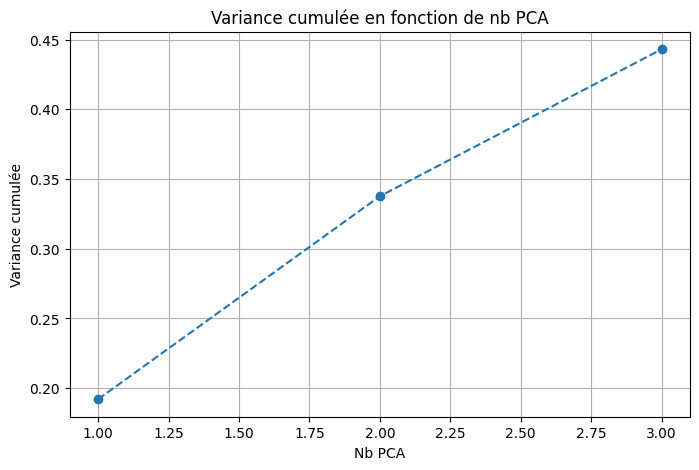

In [16]:
# Plot de notre variance expliquée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance_explicative) + 1),variance_cumul , marker='o', linestyle='--')
plt.title('Variance cumulée en fonction de nb PCA')
plt.xlabel('Nb PCA')
plt.ylabel('Variance cumulée')
plt.grid(True)
plt.show()

In [17]:
X_pca = np.concatenate((X_scaler, pca.fit_transform(X_scaler)), axis=1)

In [18]:
run_classifier(X_pca, target, clfs)

Score for CART is: 0.660 +/- 0.027
Score for ID3 is: 0.654 +/- 0.018
Score for Stump is: 0.536 +/- 0.045
Score for KNN is: 0.682 +/- 0.021
Score for Bag is: 0.693 +/- 0.022
Score for Ad is: 0.702 +/- 0.018
Score for RF is: 0.690 +/- 0.019
Score for ExtraTree is: 0.686 +/- 0.022
Score for MLP_1 is: 0.711 +/- 0.019
Score for MLP_2 is: 0.720 +/- 0.028

Best model: MLP_2 with score: 0.720


#### Meilleur algorithme qu'on va garder pour la suite : <a> MLP_2 with score: 0.720 </a> (Avec StandarScaler et ACP)

## 2. Choix des meilleurs paramètres du meilleur modèle

In [19]:
from utils import *

In [20]:
parametres = {
    'hidden_layer_sizes': [(30, 10), (40, 20), (30, 20), (40, 20, 10)],
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}

best_model = MLPClassifier(random_state=1)
GS = GridSearchCV(best_model, parametres, cv=10, scoring=moyenne_recall, n_jobs=-1)
GS.fit(X_pca, target)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=1), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(30, 10), (40, 20), (30, 20),
                                                (40, 20, 10)]},
             scoring=make_scorer(my_custom_loss_func, response_method='predict'))

In [21]:
GS.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (30, 20)}

In [22]:
GS.best_estimator_

MLPClassifier(hidden_layer_sizes=(30, 20), random_state=1)

In [23]:
GS.best_score_

np.float64(0.7146930360759616)

In [24]:
best_model = GS.best_estimator_

### Selection de variables

In [25]:
df_features = df.drop(['Status'], axis=1)
X = df_features.values
X

array([[   9.,    1.,   60., ...,    0.,  800.,  846.],
       [  17.,    1.,   60., ...,    0., 1000., 1658.],
       [  10.,    0.,   36., ...,    0., 2000., 2985.],
       ...,
       [   0.,    0.,   24., ...,    0.,  500.,  963.],
       [   0.,    1.,   48., ...,    0.,  550.,  550.],
       [   5.,    0.,   60., ..., 1000., 1350., 1650.]], shape=(4375, 13))

In [26]:
def selection_variables(X,Y,features):
    clf = RandomForestClassifier(n_estimators=1000,random_state=1)
    clf.fit(X, Y)
    importances=clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    sorted_idx = np.argsort(importances)[::-1]
    print(features[sorted_idx])
    padding = np.arange(X.size/len(X)) + 0.5
    plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
    plt.yticks(padding, features[sorted_idx])
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance")
    plt.show()
    return sorted_idx

Index(['Marital', 'Age', 'Seniority', 'Time', 'Price', 'Records', 'PCA3',
       'Debt', 'Home', 'PCA1', 'Job', 'Income', 'Assets', 'PCA2', 'Amount',
       'Expenses'],
      dtype='object')


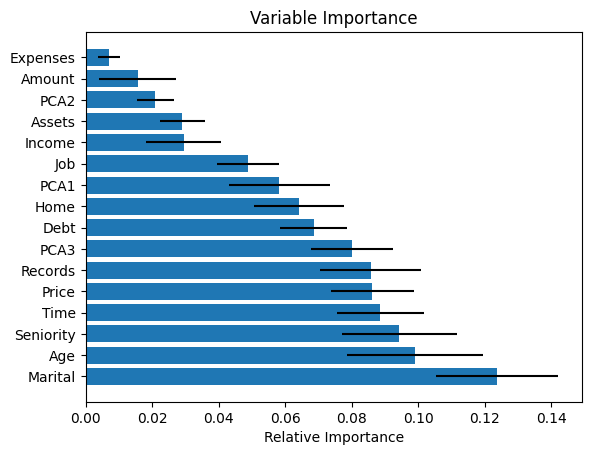

In [27]:
features = df.columns[:-1].union(['PCA1','PCA2','PCA3'])
sorted_idx = selection_variables(X_pca, target, features)

In [31]:
def nb_variables(X,Y,features, best_model, sorted_idx):
    # Initialisation
    scores = np.zeros(len(features))
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    # Boucle sur le nombre de variables à sélectionner
    for f in range(0, X.shape[1]):
        cv_moy_recall = cross_val_score(best_model, X[:,sorted_idx[:f+1]], Y, cv=kf, scoring=moyenne_recall, n_jobs=-1)
        scores[f] = np.mean(cv_moy_recall)
    # Visualisation
    plt.plot(scores) 
    plt.xlabel("Nombre de Variables")
    plt.ylabel("Moyenne des rappels")
    plt.title("Evolution de la moyenne des rappels en fonction des variables")
    plt.show()
    return scores

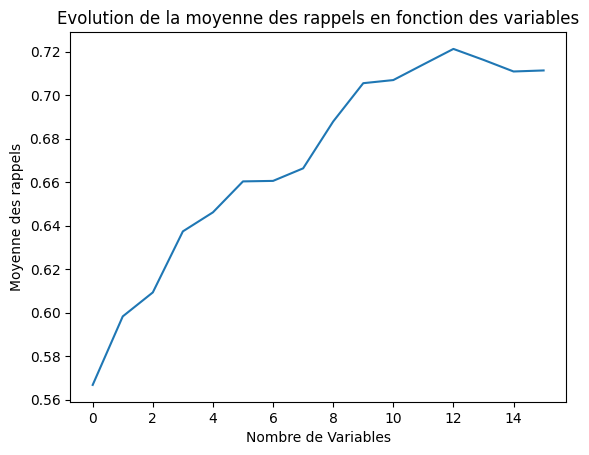

In [32]:
scores_features = nb_variables(X_pca, target, features, best_model, sorted_idx)

In [34]:
scores_features

array([0.56674332, 0.59825044, 0.60927633, 0.63734489, 0.64609423,
       0.66031808, 0.66054815, 0.66631626, 0.68785185, 0.70546878,
       0.70690391, 0.71409117, 0.72122354, 0.71618644, 0.71084873,
       0.71132416])

# 4. Automatisation du modèle

In [35]:
nb_selected = np.argmax(scores_features) + 1 

In [38]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel
import pickle

In [39]:
clf = RandomForestClassifier(n_estimators=1000, random_state=1) 

In [40]:
# Pipeline with best parameters
P = Pipeline([('ss', StandardScaler()),
              ('FU', FeatureUnion([('ss', StandardScaler()), ('pca', PCA(n_components=3))])),
              ('FS', SelectFromModel(clf, max_features=nb_selected)),
              ('classifieur', best_model)
              ])

In [41]:
P.fit(X,target)

Pipeline(steps=[('ss', StandardScaler()),
                ('FU',
                 FeatureUnion(transformer_list=[('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3))])),
                ('FS',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000,
                                                                  random_state=1),
                                 max_features=np.int64(13))),
                ('classifieur',
                 MLPClassifier(hidden_layer_sizes=(30, 20), random_state=1))])

In [43]:
pickle.dump(P,open('credit_model.pkl','wb'))

In [49]:
P

Pipeline(steps=[('ss', StandardScaler()),
                ('FU',
                 FeatureUnion(transformer_list=[('ss', StandardScaler()),
                                                ('pca', PCA(n_components=3))])),
                ('FS',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000,
                                                                  random_state=1),
                                 max_features=np.int64(13))),
                ('classifieur',
                 MLPClassifier(hidden_layer_sizes=(30, 20), random_state=1))])

# II. Apprentissage supervisé : Données hétérogènes

<hr>

In [1]:
from utils import *

### Chargement des données et préparation

In [ ]:
df = pd.read_csv("credit.data", delimiter=";", header=None)
df.head(5) 